# Super-Resolution Generative Adversarial Network training

Here in this jupyter notebook, we will train a super-resolution generative adversarial network (SRGAN), to create a high-resolution Antarctic bed Digital Elevation Model(DEM) from a low-resolution DEM.
In addition to that, we use additional correlated inputs that can also tell us something about the bed topography.

<img src="https://yuml.me/diagram/scruffy;dir:LR/class/[BEDMAP2 (1000m)]->[Generator model],[REMA (200m)]->[Generator model],[MEASURES Ice Flow Velocity (450m)]->[Generator model],[Generator model]->[High res bed DEM (250m)],[High res bed DEM (250m)]->[Discriminator model],[Groundtruth Image (250m)]->[Discriminator model],[Discriminator model]->[True/False]" alt="3 input SRGAN model"/>

## 0. Setup libraries

In [1]:
import os
import random
import sys
import typing

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import IPython.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import quilt
import skimage.transform
import tqdm

import keras
from keras import backend as K
from keras.layers import (
    Add,
    BatchNormalization,
    Concatenate,
    Conv2D,
    Conv2DTranspose,
    Dense,
    Flatten,
    Input,
    Lambda,
)
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.models import Model
from livelossplot import PlotLossesKeras

print("Python       :", sys.version.split("\n")[0])
print("Numpy        :", np.__version__)
print("Keras        :", keras.__version__)
print("Tensorflow   :", K.tf.__version__)
K.tf.test.gpu_device_name()

Using TensorFlow backend.


Python       : 3.6.6 | packaged by conda-forge | (default, Oct 11 2018, 14:33:06) 
Numpy        : 1.14.5
Keras        : 2.2.4
Tensorflow   : 1.10.1


'/device:GPU:0'

In [2]:
# Set seed values
seed = 42
random.seed = seed
np.random.seed(seed=seed)
K.tf.set_random_seed(seed=seed)

## 1. Load data

In [3]:
hash = "f4d7ff9b8c864721cfc1b4ad53901d9a491e8c72f656584ed5ec1e0bbf299915"
quilt.install(package="weiji14/deepbedmap/model/train", hash=hash, force=False)
pkg = quilt.load(pkginfo="weiji14/deepbedmap", hash=hash)

weiji14/deepbedmap/model/train already installed.


Overwrite? (y/n)  y


Fragments already downloaded


In [4]:
W1_data = pkg.model.train.W1_data()  # miscellaneous data REMA
W2_data = pkg.model.train.W2_data()  # miscellaneous data MEASURES Ice Flow
X_data = pkg.model.train.X_data()  # low resolution BEDMAP2
Y_data = pkg.model.train.Y_data()  # high resolution groundtruth
# W1_data = np.load(file="model/train/W1_data.npy")
# W2_data = np.load(file="model/train/W2_data.npy")
# X_data = np.load(file="model/train/X_data.npy")
# Y_data = np.load(file="model/train/Y_data.npy")
print(W1_data.shape, W2_data.shape, X_data.shape, Y_data.shape)

(2480, 80, 80, 1) (2480, 16, 16, 1) (2480, 8, 8, 1) (2480, 32, 32, 1)


## 2. Architect model

Super Resolution Generative Adversarial Network model based on [Ledig et al. 2017](https://arxiv.org/abs/1609.04802v5).
Keras implementation below takes some hints from https://github.com/eriklindernoren/Keras-GAN/blob/master/srgan/srgan.py

### Generator Network Architecture

![SRGAN architecture - Generator Network](https://arxiv-sanity-sanity-production.s3.amazonaws.com/render-output/399644/images/used/jpg/generator.jpg)
![3-in-1 Generator Network](https://yuml.me/0bfe11e4.png)

Details of the first convolutional layer:

- Input tiles are 8000m by 8000m.
- Convolution filter kernels are 3000m by 3000m.
- Strides are 1000m by 1000m.

Example: for a 100m spatial resolution tile:

- Input tile is 80pixels by 80pixels
- Convolution filter kernels are 30pixels by 30pixels
- Strides are 10pixels by 10pixels

Note that padding type is 'same', see https://keras.io/layers/convolutional/ for more information.

<!--[W2_input(MEASURES)|16x16x1]-k6n32s2 >[W2_inter|8x8x32],[W2_inter]->[Concat|8x8x96]
[X_input(BEDMAP2)|8x8x1]-k3n32s1 >[X_inter|8x8x32],[X_inter]->[Concat|8x8x96]
[W1_input(REMA)|80x80x1] -k30n32s10 >[W1_inter|8x8x32],[W1_inter]->[Concat|8x8x96]
[Concat|8x8x96]->[Generator-Network],[Generator-Network]->[Y_hat(High-Resolution_DEM)|32x32x1] -->

In [5]:
def generator_network(
    input1_shape: typing.Tuple[int, int, int] = (8, 8, 1),
    input2_shape: typing.Tuple[int, int, int] = (80, 80, 1),
    input3_shape: typing.Tuple[int, int, int] = (16, 16, 1),
    num_residual_blocks: int = 16,
    scaling: int = 4,
    output_channels: int = 1,
) -> keras.engine.network.Network:
    """
    The generator network which is a deconvolutional neural network.
    Converts a low resolution input into a super resolution output.

    Parameters:
      input_shape -- shape of input tensor in tuple format (height, width, channels)
      num_residual_blocks -- how many Conv-BatchNorm-PReLU-Conv-BatchNorm blocks to use
      scaling -- even numbered integer to increase resolution (e.g. 0, 2, 4, 6, 8)
      output_channels -- integer representing number of output channels/filters/kernels

    Example:
      An input_shape of (8,8,1) passing through 16 residual blocks with a scaling of 4
      and output_channels 1 will result in an image of shape (32,32,1)

    >>> generator_network().input_shape
    [(None, 8, 8, 1), (None, 80, 80, 1), (None, 16, 16, 1)]
    >>> generator_network().output_shape
    (None, 32, 32, 1)
    >>> generator_network().count_params()
    1764929
    """

    assert num_residual_blocks >= 1  # ensure that we have 1 or more residual blocks
    assert scaling % 2 == 0  # ensure scaling factor is even, i.e. 0, 2, 4, 8, etc
    assert scaling >= 0  # ensure that scaling factor is zero or a positive number
    assert output_channels >= 1  # ensure that we have 1 or more output channels

    ## Input images
    inp1 = Input(shape=input1_shape)  # low resolution image
    assert inp1.shape.ndims == 4  # needs to be shape like (?,8,8,1) for 8x8 grid
    inp2 = Input(shape=input2_shape)  # other image (e.g. REMA)
    assert inp2.shape.ndims == 4  # needs to be shape like (?,80,80,1) for 80x80 grid
    inp3 = Input(shape=input3_shape)  # other image (MEASURES Ice Flow)
    assert inp3.shape.ndims == 4  # needs to be shape like (?,16,16,1) for 16x16 grid

    # 0 part
    # Resize inputs to right scale using convolution (hardcoded kernel_size and strides)
    inp1r = Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding="same")(inp1)
    inp2r = Conv2D(filters=32, kernel_size=(30, 30), strides=(10, 10), padding="same")(
        inp2
    )
    inp3r = Conv2D(filters=32, kernel_size=(6, 6), strides=(2, 2), padding="same")(inp3)

    # Concatenate all inputs
    # SEE https://distill.pub/2016/deconv-checkerboard/
    X = Concatenate()([inp1r, inp2r, inp3r])  # Concatenate all the inputs together

    # 1st part
    # Pre-residual k3n64s1 (originally k9n64s1)
    X0 = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same")(X)
    X0 = PReLU()(X0)

    # 2nd part
    # Residual blocks k3n64s1
    def residual_block(input_tensor):
        x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same")(
            input_tensor
        )
        x = BatchNormalization()(x)
        x = PReLU()(x)
        x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same")(x)
        x = BatchNormalization()(x)
        return Add()([x, input_tensor])

    X = residual_block(X0)
    for _ in range(num_residual_blocks - 1):
        X = residual_block(X)

    # 3rd part
    # Post-residual blocks k3n64s1
    X = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same")(X)
    X = BatchNormalization()(X)
    X = Add()([X, X0])

    # 4th part
    # Upsampling (if 4; run twice, if 8; run thrice, etc.) k3n256s1
    for p, _ in enumerate(range(scaling // 2), start=1):
        X = Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding="same")(X)
        pixelshuffleup = lambda images: K.tf.depth_to_space(input=images, block_size=2)
        X = Lambda(function=pixelshuffleup, name=f"pixelshuffleup_{p}")(X)
        X = PReLU()(X)

    # 5th part
    # Generate high resolution output k9n1s1 (originally k9n3s1 for RGB image)
    outp = Conv2D(
        filters=output_channels,
        kernel_size=(9, 9),
        strides=(1, 1),
        padding="same",
        name="generator_output",
    )(X)

    # Create neural network with input low-res images and output prediction
    network = keras.engine.network.Network(
        inputs=[inp1, inp2, inp3], outputs=[outp], name="generator_network"
    )

    return network

### Discriminator Network Architecture

Discriminator component is based on Deep Convolutional Generative Adversarial Networks by [Radford et al., 2015](https://arxiv.org/abs/1511.06434).
Keras implementation below takes some hints from https://github.com/erilyth/DCGANs/blob/master/DCGAN-CIFAR10/dcgan.py and https://github.com/yashk2810/DCGAN-Keras/blob/master/DCGAN.ipynb

![SRGAN architecture - Discriminator Network](https://arxiv-sanity-sanity-production.s3.amazonaws.com/render-output/399644/images/used/jpg/discriminator.jpg)

![Discriminator Network](https://yuml.me/diagram/scruffy/class/[High-Resolution_DEM|32x32x1]->[Discriminator-Network],[Discriminator-Network]->[False/True|0/1])

In [6]:
def discriminator_network(
    input_shape: typing.Tuple[int, int, int] = (32, 32, 1)
) -> keras.engine.network.Network:
    """
    The discriminator network which is a convolutional neural network.
    Takes ONE high resolution input image and predicts whether it is
    real or fake on a scale of 0 to 1, where 0 is fake and 1 is real.

    >>> discriminator_network().input_shape
    (None, 32, 32, 1)
    >>> discriminator_network().output_shape
    (None, 1)
    >>> discriminator_network().count_params()
    6828033
    """

    ## Input images
    inp = Input(shape=input_shape)  # high resolution/groundtruth image to discriminate
    assert inp.shape.ndims == 4  # needs to be shape like (?,32,32,1) for 8x8 grid

    # 1st part
    # Convolutonal Block without Batch Normalization k3n64s1
    X = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same")(inp)
    X = LeakyReLU(alpha=0.2)(X)

    # 2nd part
    # Convolutional Blocks with Batch Normalization k3n{64*f}s{1or2}
    for f, s in zip([1, 1, 2, 2, 4, 4, 8, 8], [1, 2, 1, 2, 1, 2, 1, 2]):
        X = Conv2D(filters=64 * f, kernel_size=(3, 3), strides=(s, s), padding="same")(
            X
        )
        X = LeakyReLU(alpha=0.2)(X)
        X = BatchNormalization()(X)

    # 3rd part
    # Flatten, Dense (Fully Connected) Layers and Output
    X = Flatten()(X)
    X = Dense(units=1024)(X)  # ??!! Flatten?
    X = LeakyReLU(alpha=0.2)(X)
    outp = Dense(units=1, activation="sigmoid", name="discriminator_output")(X)

    # Create neural network with input highres/groundtruth images, output validity 0/1
    network = keras.engine.network.Network(
        inputs=[inp], outputs=[outp], name="discriminator_network"
    )

    return network

### Combine Generator and Discriminator Networks

Here we combine the Generator and Discriminator neural network models together, and define the Perceptual Loss function where:

$$Perceptual Loss = Content Loss + Adversarial Loss$$

The original SRGAN paper by [Ledig et al. 2017](https://arxiv.org/abs/1609.04802v5) calculates *Content Loss* based on the ReLU activation layers of the pre-trained 19 layer VGG network.
The implementation below is less advanced, simply using a pixel-wise [Mean Squared Error (MSE) loss](https://keras.io/losses/#mean_squared_error) as the *Content Loss*.
Specifically, the *Content Loss* is calculated as the MSE difference between the output of the generator model (i.e. the predicted Super Resolution Image) and that of the groundtruth image (i.e. the true High Resolution Image).

The *Adversarial Loss* or *Generative Loss* (confusing I know) is the same as in the original SRGAN paper.
It is defined based on the probabilities of the discriminator believing that the reconstructed Super Resolution Image is a natural High Resolution Image.
The implementation below uses the [Binary CrossEntropy loss](https://keras.io/losses/#binary_crossentropy).
Specifically, this *Adversarial Loss* is calculated between the output of the discriminator model (a value between 0 and 1) and that of the groundtruth label (a boolean value of either 0 or 1).

Source code for the implementations of these loss functions in Keras can be found at https://github.com/keras-team/keras/blob/master/keras/losses.py.

![Perceptual Loss in a Super Resolution Generative Adversarial Network](https://yuml.me/69dc9a87.png)

<!--
[LowRes-Inputs]-Generator>[SuperResolution_DEM]
[SuperResolution_DEM]-.->[note:Content-Loss|MeanSquaredError{bg:yellow}]
[HighRes-Groundtruth_DEM]-.->[note:Content-Loss]
[SuperResolution_DEM]-Discriminator>[False_or_True_Prediction]
[HighRes-Groundtruth_DEM]-Discriminator>[False_or_True_Prediction]
[False_or_True_Prediction]<->[False_or_True_Label]
[False_or_True_Prediction]-.->[note:Adversarial-Loss|BinaryCrossEntropy{bg:yellow}]
[False_or_True_Label]-.->[note:Adversarial-Loss]
[note:Content-Loss]-.->[note:Perceptual-Loss{bg:gold}]
[note:Adversarial-Loss]-.->[note:Perceptual-Loss{bg:gold}]
-->

In [7]:
def compile_srgan_model(
    g_network: keras.engine.network.Network,
    d_network: keras.engine.network.Network,
    metrics: typing.Dict[str, str] = None,
) -> typing.Dict[str, keras.engine.training.Model]:
    """
    Creates a Super Resolution Generative Adversarial Network (SRGAN)
    by joining a generator network with a discriminator network.

    Returns a dictionary containing:
    1) generator model (trainable, not compiled)
    2) discriminator model (trainable, compiled)
    3) srgan model (trainable generator, untrainable discriminator, compiled)

    The SRGAN model will be compiled with an optimizer (e.g. Adam)
    and have separate loss functions and metrics for its
    generator and discriminator component.

    >>> metrics = {"generator_network": 'mse', "discriminator_network": 'accuracy'}
    >>> models = compile_srgan_model(
    ...     g_network=generator_network(),
    ...     d_network=discriminator_network(),
    ...     metrics=metrics,
    ... )
    >>> models['discriminator_model'].trainable
    True
    >>> models['srgan_model'].get_layer(name='generator_network').trainable
    True
    >>> models['srgan_model'].get_layer(name='discriminator_network').trainable
    False
    >>> models['srgan_model'].count_params()
    8592962
    """

    # Check that our neural networks are named properly
    assert g_network.name == "generator_network"
    assert d_network.name == "discriminator_network"
    assert g_network.trainable == True  # check that generator is trainable
    assert d_network.trainable == True  # check that discriminator is trainable

    ## Both trainable
    # Create keras models (trainable) out of the networks (graph only)
    g_model = Model(
        inputs=g_network.inputs, outputs=g_network.outputs, name="generator_model"
    )
    d_model = Model(
        inputs=d_network.inputs, outputs=d_network.outputs, name="discriminator_model"
    )
    d_model.compile(
        optimizer=keras.optimizers.Adam(lr=0.001),
        loss={"discriminator_output": keras.losses.binary_crossentropy},
    )

    ## One trainable (generator), one untrainable (discriminator)
    # Connect Generator Network to Discriminator Network
    g_out = g_network(inputs=g_network.inputs)  # g_in --(g_network)--> g_out
    d_out = d_network(inputs=g_out)  # g_out --(d_network)--> d_out

    # Create and Compile the Super Resolution Generative Adversarial Network Model!
    model = Model(inputs=g_network.inputs, outputs=[g_out, d_out])
    model.get_layer(
        name="discriminator_network"
    ).trainable = False  # combined model should not train discriminator
    model.compile(
        optimizer=keras.optimizers.Adam(lr=0.001),
        loss={
            "generator_network": keras.losses.mean_squared_error,
            "discriminator_network": keras.losses.binary_crossentropy,
        },
        metrics=metrics,
    )

    return {
        "generator_model": g_model,
        "discriminator_model": d_model,
        "srgan_model": model,
    }

In [8]:
def psnr(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    """
    Peak Signal-Noise Ratio (PSNR) metric.
    See https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio#Definition

    >>> y_true, y_pred = np.ones(shape=(3, 3)), np.full(shape=(3, 3), fill_value=2)
    >>> K.eval(psnr(y_true=y_true, y_pred=y_pred))
    array([221.80709678, 221.80709678, 221.80709678])
    """

    mse = (
        K.mean(K.square(K.np.subtract(y_pred, y_true)), axis=-1) + K.epsilon()
    )  # add epsilon to prevent zero division
    return K.np.multiply(
        20, K.log(2 ** 16 / K.sqrt(mse))
    )  # setting MAX_I as 2^16, i.e. max for int16

In [9]:
K.clear_session()  # Reset Keras/Tensorflow graph
metrics = {"generator_network": psnr, "discriminator_network": "accuracy"}
models = compile_srgan_model(
    g_network=generator_network(), d_network=discriminator_network(), metrics=metrics
)
models["srgan_model"].summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 8, 8, 1)      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 80, 80, 1)    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 16, 16, 1)    0                                            
__________________________________________________________________________________________________
generator_network (Network)     (None, 32, 32, 1)    1764929     input_1[0][0]                    
                                                                 input_2[0][0]                    
          

## 3. Train model

[Gherkin](https://en.wikipedia.org/wiki/Gherkin_(language))/Plain English statement at what the Super-Resolution Generative Adversarial Network below does

```gherkin
    # language: en
    Feature: SRGAN DeepBedMap
      In order to create a great map of Antarctica's bed
      As a data scientist,
      We want a model that produces realistic images from many open datasets

      Scenario: Train discriminator to beat generator
        Given fake generated images from a generator
          And real groundtruth images
         When the two sets of images are fed into the discriminator
         Then the discriminator should know the fakes from the real images

      Scenario: Train generator to fool discriminator
        Given what we think the discriminator believes is real
         When our inputs are fed into the super resolution model
         Then the generator should create a more authentic looking image
```

In [10]:
def train_discriminator(
    models: typing.Dict[str, keras.engine.training.Model],
    generator_inputs: typing.List[np.ndarray],
    groundtruth_images: np.ndarray,
    verbose: int = 1,
) -> (typing.Dict[str, keras.engine.training.Model], list):
    """
    Trains the Discriminator within a Super Resolution Generative Adversarial Network.
    Discriminator is trainable, Generator is not trained (only produces predictions).

    Steps:
    - Generator produces fake images
    - Fake images combined with real groundtruth images
    - Discriminator trained with these images and their Fake(0)/Real(1) labels

    >>> generator_inputs = [
    ...     np.random.RandomState(seed=42).rand(32, s, s, 1) for s in [8, 80, 16]
    ... ]
    >>> groundtruth_images = np.random.RandomState(seed=42).rand(32,32,32,1)
    >>> models = compile_srgan_model(
    ...     g_network=generator_network(), d_network=discriminator_network()
    ... )

    >>> d_weight0 = K.eval(models['discriminator_model'].weights[0][0,0,0,0])
    >>> _, _ = train_discriminator(
    ...     models=models,
    ...     generator_inputs=generator_inputs,
    ...     groundtruth_images=groundtruth_images,
    ...     verbose=0,
    ... )
    >>> d_weight1 = K.eval(models['discriminator_model'].weights[0][0,0,0,0])

    >>> d_weight0 != d_weight1  #check that training has occurred (i.e. weights changed)
    True
    """

    assert (
        len(generator_inputs) == 3
    )  # hardcoded check that we are passing in 3 numpy arrays as input
    assert (
        generator_inputs[0].shape[0] == generator_inputs[1].shape[0]
    )  # check that X_data and W1_data have same length (batch size)
    assert (
        generator_inputs[0].shape[0] == generator_inputs[2].shape[0]
    )  # check that X_data and W2_data have same length (batch size)

    # @pytest.fixture
    g_model = models["generator_model"]
    d_model = models["discriminator_model"]

    # @given("fake generated images from a generator")
    fake_images = g_model.predict(x=generator_inputs, batch_size=32)
    fake_labels = np.zeros(shape=len(generator_inputs[0]))

    # @given("real groundtruth images")
    real_images = groundtruth_images  # groundtruth images i.e. Y_data
    real_labels = np.ones(shape=len(groundtruth_images))

    # @when("the two sets of images are fed into the discriminator")
    images = np.concatenate([fake_images, real_images])
    labels = np.concatenate([fake_labels, real_labels])
    assert d_model.trainable == True
    d_metrics = d_model.fit(x=images, y=labels, batch_size=32, verbose=verbose).history

    # @then("the discriminator should know the fakes from the real images")
    # assert d_weight0 != d_weight1  # check that training occurred i.e. weights changed

    return models, [m[0] for m in d_metrics.values()]

In [11]:
def train_generator(
    models: typing.Dict[str, keras.engine.training.Model],
    generator_inputs: typing.List[np.ndarray],
    groundtruth_images: np.ndarray,
    verbose: int = 1,
) -> (typing.Dict[str, keras.engine.training.Model], list):
    """
    Trains the Generator within a Super Resolution Generative Adversarial Network.
    Discriminator is not trainable, Generator is trained.

    Steps:
    - Labels of the SRGAN output are set to Real(1)
    - Generator is trained to match these Real(1) labels

    >>> generator_inputs = [
    ...     np.random.RandomState(seed=42).rand(32, s, s, 1) for s in [8, 80, 16]
    ... ]
    >>> groundtruth_images = np.random.RandomState(seed=42).rand(32,32,32,1)
    >>> models = compile_srgan_model(
    ...     g_network=generator_network(), d_network=discriminator_network()
    ... )

    >>> g_weight0 = K.eval(models['generator_model'].weights[0][0,0,0,0])
    >>> _, _ = train_generator(
    ...     models=models,
    ...     generator_inputs=generator_inputs,
    ...     groundtruth_images=groundtruth_images,
    ...     verbose=0,
    ... )
    >>> g_weight1 = K.eval(models['generator_model'].weights[0][0,0,0,0])

    >>> g_weight0 != g_weight1  #check that training has occurred (i.e. weights changed)
    True
    """

    # @pytest.fixture
    srgan_model = models["srgan_model"]

    # @given("what we think the discriminator believes is real")
    true_labels = np.ones(shape=len(generator_inputs[0]))

    # @when("our inputs are fed into the super resolution model")
    assert srgan_model.get_layer(name="discriminator_network").trainable == False
    g_metrics = srgan_model.fit(
        x=generator_inputs,
        y={
            "generator_network": groundtruth_images,
            "discriminator_network": true_labels,
        },
        batch_size=32,
        verbose=verbose,
    ).history

    # @then("the generator should create a more authentic looking image")
    # assert g_weight0 != g_weight1  # check that training occurred i.e. weights changed

    return models, [m[0] for m in g_metrics.values()]

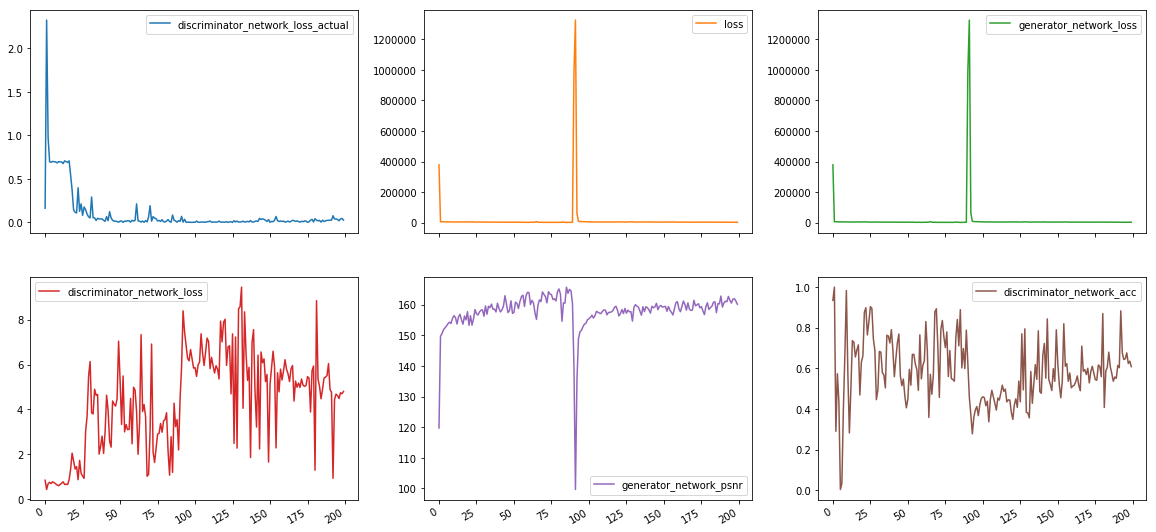

100%|██████████| 200/200 [35:12<00:00, 10.39s/it, discriminator_network_loss_actual=0.0266, loss=3.77e+3, generator_network_loss=3.77e+3, discriminator_network_loss=4.8, generator_network_psnr=160, discriminator_network_acc=0.608]


In [12]:
epochs = 200
with tqdm.trange(epochs) as t:
    columns = ["discriminator_network_loss_actual"] + models[
        "srgan_model"
    ].metrics_names
    dataframe = pd.DataFrame(index=np.arange(0, epochs), columns=columns)
    for i in t:
        ## Part 1 - Train Discriminator
        _, d_metrics = train_discriminator(
            models=models,
            generator_inputs=[X_data, W1_data, W2_data],
            groundtruth_images=Y_data,
        )

        ## Part 2 - Train Generator
        _, g_metrics = train_generator(
            models=models,
            generator_inputs=[X_data, W1_data, W2_data],
            groundtruth_images=Y_data,
        )

        ## Plot loss and metric information using pandas plot
        dataframe.loc[i] = d_metrics + g_metrics
        dataframe.plot(subplots=True, figsize=(20, 10), layout=(2, 3))
        IPython.display.clear_output(wait=True)
        plt.show()

        t.set_postfix(ordered_dict=dataframe.loc[i].to_dict())

In [13]:
model = models["generator_model"]

In [14]:
os.makedirs(name="model/weights", exist_ok=True)
# generator model's parameter weights and architecture
model.save(filepath="model/weights/srgan_generator_model.hdf5")
# just the model weights
model.save_weights(filepath="model/weights/srgan_generator_model_weights.hdf5")
# just the model architecture
with open("model/weights/srgan_generator_model_architecture.json", "w") as json_file:
    json_file.write(model.to_json(indent=2))

In [15]:
raise ValueError("temp")

ValueError: temp

## 4. Evaluate model

In [ ]:
Y_hat = model.predict(x=[X_data, W1_data, W2_data], verbose=1)
print(Y_hat.shape, Y_hat.dtype)

In [ ]:
for i in range(5):
    try:
        id = random.randrange(0, len(X_data))
        print(id, X_data[id].shape)

        X_cube = skimage.transform.rescale(
            image=X_data[id].astype(np.int32),
            scale=4,
            order=3,
            mode="reflect",
            anti_aliasing=True,
            multichannel=False,
        )
        psnr_bicubic = skimage.measure.compare_psnr(
            im_true=Y_data[id][:, :, 0].astype(np.int32),
            im_test=X_cube[:, :, 0].astype(np.int32),
        )
        psnr_srgan = skimage.measure.compare_psnr(
            im_true=Y_data[id][:, :, 0].astype(np.int32),
            im_test=Y_hat[id][:, :, 0].astype(np.int32),
        )

        fig, axarr = plt.subplots(nrows=1, ncols=5, squeeze=False, figsize=(15, 15))
        axarr[0, 0].imshow(
            X_data[id][:, :, 0], aspect="equal"
        )  # low resolution original
        axarr[0, 1].imshow(X_cube[:, :, 0], aspect="equal")  # bicubic interpolation
        axarr[0, 2].imshow(W1_data[id][:, :, 0], aspect="equal")  # REMA surface DEM
        axarr[0, 3].imshow(Y_hat[id][:, :, 0], aspect="equal")  # srcnn prediction
        axarr[0, 4].imshow(Y_data[id][:, :, 0], aspect="equal")  # groundtruth

        axarr[0, 0].set_title("BEDMAP2")
        axarr[0, 1].set_title("Bicubic")
        axarr[0, 1].set_xlabel(f"PSNR: {psnr_bicubic:.2f}")
        axarr[0, 2].set_title("REMA")
        axarr[0, 3].set_xlabel(f"PSNR: {psnr_srgan:.2f}")
        axarr[0, 3].set_title("SRGAN")
        axarr[0, 4].set_title("Groundtruth")

        plt.show()
    except TypeError:
        pass